In [3]:
import pandas as pd
import numpy as np
import graph_tool as gt
import datetime
import itertools as it
import matplotlib.pyplot as plt
from graph_tool import stats as gt_stats
from graph_tool.draw import graph_draw

In [4]:
#### READ IN THE DATASETS

co_offending_table = pd.read_csv('./raw_datasets/Cooffending.csv')
crimes = pd.read_csv('./processed_datasets/crime_type_mapping.csv')

#### CLEAN 
co_offending_table.drop_duplicates(inplace=True)

def crime_category_to_int(x):
    if x == 'x':
        return(0)
    else:
        return(int(x))

crimes['criminology_category'] = crimes.criminology_category.apply(crime_category_to_int)

# Format the crime labels with 0 corresponding to a missing value 
def crime_code_to_int(x):
    if x == ' ':
        return 0 
    else:
        return int(x)
    
co_offending_table['NCD1'] = co_offending_table.NCD1.apply(crime_code_to_int)
co_offending_table['NCD2'] = co_offending_table.NCD2.apply(crime_code_to_int)
co_offending_table['NCD3'] = co_offending_table.NCD3.apply(crime_code_to_int)
co_offending_table['NCD4'] = co_offending_table.NCD4.apply(crime_code_to_int)

# Only look at entries that have crime identified 
co_offending_table = co_offending_table[co_offending_table.NCD1 != 0]

In [90]:
co_offending_table[co_offending_table.NoUnique == 623341]['NCD1']

1189653    1420
1189654    1430
Name: NCD1, dtype: int64

In [94]:
crimes[crimes.crime_code ==1420 ]

,crime_code,text_description,criminology_category,group_crime,drug_crime,drug_usage,drug_trafficking
23,1420,AGR.ARMEE OU LESIONS NIV2,1,0,0,0,0


In [5]:
## Constructing the Network

def build_crime_relationship_graph(crime_df, co_offending_df):
    # verticies are crime codes
    N = len(crime_df['crime_code'])
    
    # represent as a graph
    g= gt.Graph(directed=False)
    g.add_vertex(N)
    
    # store properties     
    crime_description = g.new_vertex_property("string")
    crime_code = g.new_vertex_property("int")
    crime_category = g.new_vertex_property("int")
    drug_crime = g.new_vertex_property("int")
    edge_weight = g.new_edge_property("int")
    
    # also keep a mapping from vertex indicies back to crime codes
    crime_code_to_index = {}
    
    for (vertex_index, row) in crime_df.iterrows():
        crime_description[vertex_index] = row['text_description']
        crime_code[vertex_index] = row['crime_code']
        crime_category[vertex_index] = row['criminology_category']
        drug_crime[vertex_index] = row['drug_crime']
        crime_code_to_index[row['crime_code']] = vertex_index
    
    print('nodes added')
    # get an iterator over edges
    crimes_committed_together = co_offending_table.groupby('NoUnique').apply(
        lambda x: it.combinations(map(lambda y: crime_code_to_index[y], np.unique(x.NCD1.values)), 2))
    
    print('edge iterator built')
    
    # go through an calculate the weights 
    edges_with_weights = {}
    for pair in crimes_committed_together:
        for (vertex_1, vertex_2) in pair:
            if vertex_1 == vertex_2:
                continue
            if (vertex_1, vertex_2) in edges_with_weights.keys() and (vertex_2, vertex_1) in edges_with_weights.keys():
                edges_with_weights[(vertex_1, vertex_2)] += 1
                edges_with_weights[(vertex_2, vertex_1)] += 1
            else:
                edges_with_weights[(vertex_1, vertex_2)] = 1 
                edges_with_weights[(vertex_2, vertex_1)] = 1
    
    print('edge weights calulated')
    print('adding edges to graph')
    
    # now add edges and weights to the graph 
    for (edge, weight) in edges_with_weights.items():
        vertex_1 = edge[0]
        vertex_2 = edge[1]
        g.add_edge(vertex_1, vertex_2)
        edge_weight[(vertex_1, vertex_2)] = weight
    
    print('edges added to graph')
        
    g.edge_properties['weight'] = edge_weight
    g.vertex_properties['crime_code'] = crime_code
    g.vertex_properties['crime_description'] = crime_description
    g.vertex_properties['criminology_category'] = crime_category
    g.vertex_properties['drug_crime'] = drug_crime
    
    # also remove the parallel edges 
    gt.stats.remove_parallel_edges(g)
    
    return(g)

In [6]:
g = build_crime_relationship_graph(crimes, co_offending_table)

nodes added
edge iterator built
edge weights calulated
adding edges to graph
edges added to graph


In [12]:
g.save("./crime_type_graph.gml")

In [13]:
g= gt.Graph(directed=False)
g.load(file_name="./crime_type_graph.gml")

In [132]:
g.set_vertex_filter(None)

In [133]:
print(g.num_vertices(), g.num_edges())

385 13775


In [134]:
degree_map = g.degree_property_map('out',weight=g.edge_properties['weight'])

In [135]:
log_weight = g.new_edge_property("float")

for edge in g.edges():
    if g.edge_properties['weight'][edge] == 0:
        log_weight[edge] = 0
    else:
        log_weight[edge] = np.log(g.edge_properties['weight'][edge])

g.edge_properties['log_weight'] = log_weight

log_degree_map = g.degree_property_map('out',weight=g.edge_properties['log_weight'])

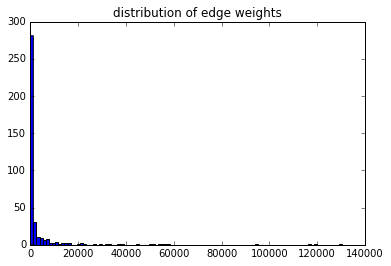

In [136]:
weights = [degree_map[vertex] for vertex in g.vertices()]
plt.hist(weights, bins=100)
plt.title('distribution of edge weights')
plt.show()

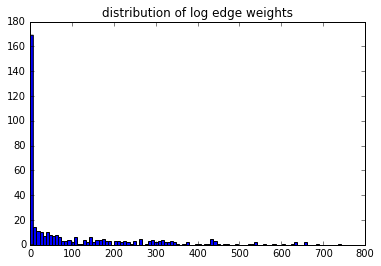

In [137]:
log_weights = [log_degree_map[vertex] for vertex in g.vertices()]
plt.hist(log_weights, bins=100)
plt.title('distribution of log edge weights')
plt.show()

In [138]:
filter_map = g.new_vertex_property('bool')

In [139]:
np.percentile(weights, 50) # we take the crimes for which we have the most information

86.0

In [140]:
for vertex in g.vertices():
    if degree_map[vertex] > 1 and g.vertex_properties['criminology\x00category'][vertex] != 0:
        filter_map[vertex] = True
    else:
        filter_map[vertex] =  False

In [141]:
g.set_vertex_filter(filter_map)

In [167]:
print(g.num_vertices(), g.num_edges())

168 6051


In [145]:
[(g.vertex_properties['crime\x00description'][vertex], degree_map[vertex])  for vertex in g.vertices()]

[('MEURTRE PREMIER DEGRE', 433.0),
 ('MEURTRE DEUXIEME DEGRE', 238.0),
 ('HOMICIDE INVOL. COUPABLE', 109.0),
 ('NEGLIGENCE CRIMIN. MORT', 166.0),
 ('AUTRES INFRACTIONS MORT', 19.0),
 ('TENTATIVE DE MEURTRE', 3069.0),
 ('CONSPIRATION MEURTRE', 233.0),
 ('AGRESSION SEXUELLE GRAVE', 390.0),
 ('AGRESSION SEXUELLE ARMEE', 691.0),
 ('AGRESSION SEXUELLE', 15374.0),
 ('AUTRE INFRACTION SEXUELLE', 2940.0),
 ('CONTACT SEXUEL', 369.0),
 ('INCITATION CONTACT SEXUEL', 113.0),
 ('INCESTE', 25.0),
 ("CORRUPTION D''ENFANT", 7.0),
 ('LEURRE AVEC UN ORDINATEUR', 21.0),
 ('RELATION SEXUELLE ANALE', 4.0),
 ('VOYEURISME', 63.0),
 ('VOIES DE FAIT GRAVES NIV3', 4558.0),
 ('AGR.ARMEE OU LESIONS NIV2', 57633.0),
 ('VOIES DE FAIT NIV.1', 130339.0),
 ('INFLIGER ILLEGAL. LESIONS', 1700.0),
 ('DECH. ARME AVEC INTENTION', 292.0),
 ('NEGLIGENCE CRIM. LESIONS', 511.0),
 ('AUTRES VOIES DE FAIT', 1289.0),
 ("PRISE D''OTAGE", 52.0),
 ('TRAITE DE PERSONNE', 17.0),
 ('ENLEVEMENT MOINS 14 ANS', 59.0),
 ('ENLEVEMENT MOINS 1

In [146]:
block_model_unweighted_3_class = gt.inference.minimize_blockmodel_dl(g,B_max=3, B_min=3)

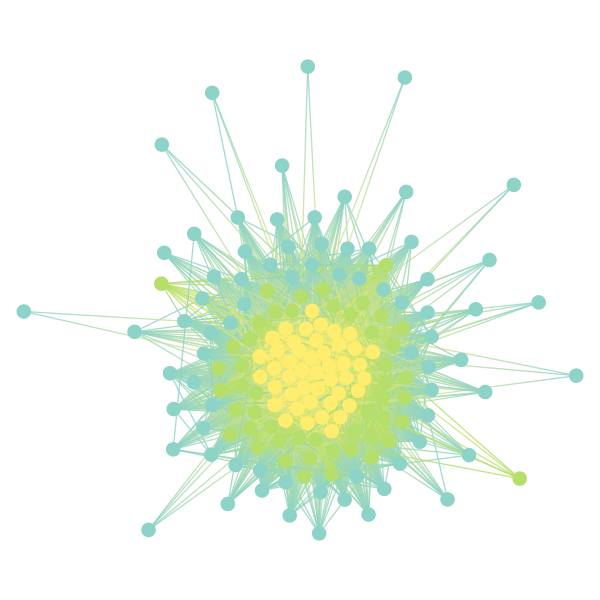

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f77602546d8, at 0x7f774caa5908>

In [168]:
block_model_unweighted_3_class.draw()

In [147]:
block_model_unweighted_3_class.entropy()

8698.6151238906914

In [148]:
block_model_unweighted_multi_class = gt.inference.minimize_blockmodel_dl(g, B_max=None, B_min=None)

In [149]:
block_model_unweighted_multi_class.entropy()

8695.3080191146692

In [150]:
block_model_weighted_3_class = gt.inference.minimize_blockmodel_dl(g,B_max=3, B_min=3, state_args=dict(recs=[g.edge_properties['weight']],
                                                               rec_types=["real-exponential"]))

In [151]:
block_model_weighted_3_class.entropy()

29893.025567666376

In [152]:
block_model_weighted_multi_class = gt.inference.minimize_blockmodel_dl(g,B_max=None, B_min=None, state_args=dict(recs=[g.edge_properties['weight']],
                                                               rec_types=["discrete-geometric"]))

In [153]:
block_model_weighted_multi_class.entropy()

28839.816793033173

In [154]:
block_model_log_weighted_3_class = gt.inference.minimize_blockmodel_dl(g,B_max=3, B_min=3, state_args=dict(recs=[g.edge_properties['log_weight']],
                                                               rec_types=["real-exponential"]))

In [155]:
block_model_log_weighted_3_class.entropy()

15713.634909455574

In [156]:
block_model_log_weighted_multi_class = gt.inference.minimize_blockmodel_dl(g,B_max=None, B_min=None, state_args=dict(recs=[g.edge_properties['log_weight']],
                                                               rec_types=["real-exponential"]))

In [157]:
block_model_log_weighted_multi_class.entropy()

14955.578522948423

In [158]:
models = [block_model_unweighted_3_class, block_model_unweighted_multi_class, 
          block_model_weighted_3_class, block_model_weighted_multi_class,
          block_model_log_weighted_3_class, block_model_log_weighted_multi_class]

In [159]:
def get_results_of_block_model(model, graph):
    rows = []
    for vertex in graph.vertices():
        crime_code = graph.vertex_properties['crime\x00code'][vertex]
        crime_description = graph.vertex_properties['crime\x00description'][vertex]
        criminology_category = graph.vertex_properties['criminology\x00category'][vertex]
        drug_crime = graph.vertex_properties['drug\x00crime'][vertex]
        group = model.b[vertex]
        rows.append({'crime_code': crime_code, 
                     'crime_description': crime_description, 
                     'criminology_category': criminology_category,
                     'drug_crime': drug_crime,
                     'group':group})
    result = pd.DataFrame(rows)
    return(result)
    

In [160]:
def visualize_distribution(grouping_df):
    plt.hist(grouping_df.group,
             range=(0,max(grouping_df.group)), bins=max(grouping_df.group)+1)
    plt.show()

In [161]:
def print_group_members_and_stats(grouping_df):
    groups = np.unique(grouping_df.group)
    for group in groups:
        print("-------------------- GROUP %i -----------------------" % group)
        count_total = len(grouping_df[grouping_df.group == group])
        count_category_0 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 0)])
        count_category_1 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 1)])
        count_category_2 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 2)])
        count_category_3 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 3)])
        count_drug = len(grouping_df[(grouping_df.group == group) & (grouping_df.drug_crime == 1)])
        print('count: %i' % count_total)
        print('share of category 1: %f' % (count_category_1/count_total))
        print('share of category 2: %f' % (count_category_2/count_total))
        print('share of category 3: %f' % (count_category_3/count_total))
        print('share of drug crime: %f' % (count_drug/count_total))
        print(grouping_df[grouping_df.group == group][['crime_description', 'criminology_category']])

In [162]:
def print_crime_category_distribution(crime_df):
    count_total = len(crime_df)
    count_category_0 = len(crime_df[(crime_df.criminology_category == 0)])
    count_category_1 = len(crime_df[(crime_df.criminology_category == 1)])
    count_category_2 = len(crime_df[(crime_df.criminology_category == 2)])
    count_category_3 = len(crime_df[(crime_df.criminology_category == 3)])
    count_drug = len(crime_df[(crime_df.drug_crime == 1)])
    print('count: %i' % count_total)
    print('share of category 1: %f' % (count_category_1/count_total))
    print('share of category 2: %f' % (count_category_2/count_total))
    print('share of category 3: %f' % (count_category_3/count_total))
    print('share of drug crime: %f' % (count_drug/count_total))

In [163]:
def print_group_stats(grouping_df):
    groups = np.unique(grouping_df.group)
    print("-------------------- PRIOR -----------------------")
    print_crime_category_distribution(grouping_df)
    for group in groups:
        print("-------------------- GROUP %i -----------------------" % group)
        count_total = len(grouping_df[grouping_df.group == group])
        count_category_0 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 0)])
        count_category_1 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 1)])
        count_category_2 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 2)])
        count_category_3 = len(grouping_df[(grouping_df.group == group) & (grouping_df.criminology_category == 3)])
        count_drug = len(grouping_df[(grouping_df.group == group) & (grouping_df.drug_crime == 1)])
        print('count: %i' % count_total)
        print('share of category 1: %f' % (count_category_1/count_total))
        print('share of category 2: %f' % (count_category_2/count_total))
        print('share of category 3: %f' % (count_category_3/count_total))
        print('share of drug crime: %f' % (count_drug/count_total))
        

In [164]:
def analyze_model(model):
    results_df = get_results_of_block_model(model, g)
    print_group_stats(results_df)
    print_group_members_and_stats(results_df)

In [165]:
def analyze_models(models):
    for model in models:
        print("MODEL %s" % str(model))
        analyze_model(model)
        print("\n\n\n\n")

In [166]:
analyze_models(models)

MODEL <BlockState object with 3 blocks (3 nonempty), degree-corrected, for graph <Graph object, undirected, with 168 vertices and 6051 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f77602546d8, at 0x7f776077a828>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f77602546d8, at 0x7f774c8ad6a0>, False) at 0x7f77602546d8>, at 0x7f774035d940>
-------------------- PRIOR -----------------------
count: 168
share of category 1: 0.315476
share of category 2: 0.208333
share of category 3: 0.476190
share of drug crime: 0.202381
-------------------- GROUP 0 -----------------------
count: 50
share of category 1: 0.340000
share of category 2: 0.280000
share of category 3: 0.380000
share of drug crime: 0.140000
-------------------- GROUP 1 -----------------------
count: 73
share of category 1: 0.342466
share of category 2: 0.095890
share of category 3: 0.561644
share of drug crime: 0.

share of category 1: 0.281250
share of category 2: 0.281250
share of category 3: 0.437500
share of drug crime: 0.187500
             crime_description  criminology_category
9           AGRESSION SEXUELLE                   1.0
19   AGR.ARMEE OU LESIONS NIV2                   1.0
20         VOIES DE FAIT NIV.1                   1.0
31        HARCELEMENT CRIMINEL                   1.0
34        PROFERER DES MENACES                   1.0
38                       RECEL                   3.0
51         POSSESSION D''ARMES                   3.0
56    INFRACTION CAUTIONNEMENT                   3.0
61          COCAINE POSSESSION                   3.0
62    AUTRE SUBSTANCE POSSESS.                   3.0
63         CANNABIS POSSESSION                   3.0
67              COCAINE TRAFIC                   3.0
69             CANNABIS TRAFIC                   3.0
83       VOIE DE FAIT POLICIER                   1.0
86               SEQUESTRATION                   1.0
87   VOL QUALIFIE SUR PERSONNE  

share of category 3: 0.326531
share of drug crime: 0.142857
             crime_description  criminology_category
0        MEURTRE PREMIER DEGRE                   1.0
5         TENTATIVE DE MEURTRE                   1.0
8     AGRESSION SEXUELLE ARMEE                   1.0
10   AUTRE INFRACTION SEXUELLE                   1.0
18   VOIES DE FAIT GRAVES NIV3                   1.0
21   INFLIGER ILLEGAL. LESIONS                   1.0
24        AUTRES VOIES DE FAIT                   1.0
32   APPELS TEL. INDEC.HARASS.                   1.0
33   AUTRE CRIME AVEC VIOLENCE                   1.0
41                PROXENETISME                   3.0
43     AUTRE ACTE PROSTITUTION                   3.0
48   USAGE ARME FEU FAUSSE ARM                   3.0
50   POS ARMES EN CONTRAV ORDO                   3.0
53   USAGE DANGEREUX ARME A FE                   3.0
55   ENTREPOSAGE NON SECUR ARM                   3.0
57       UTIL DE MONN CONTREF.                   3.0
60          HEROINE POSSESSION         